In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# defining global variable path
image_path_smoke = r"../database_smoke_net/Smoke"
image_path_land = r"../database_smoke_net/Land"

'''function to load folder into arrays and 
then it returns that same array'''
def load_images(path):
    list_of_files = []
    dirName = path
    for (dirpath, dirnames, filenames) in os.walk(dirName):
        list_of_files += [os.path.join(dirpath, file) for file in filenames]
    return list_of_files
list_files_smoke = load_images(image_path_smoke)
list_files_land = load_images(image_path_land)

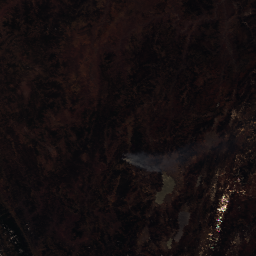

In [17]:
from scipy import ndimage#
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
load_img(list_files[0])

In [18]:
import gc
def load_images_from_list(image_list):
    images = []
    i = 1
    for image_path in image_list: 
        f = open(image_path, 'rb')
        image= (load_img(image_path))
        image_arr = img_to_array(image).flatten()
        images.append(image_arr)
        image.close()
        del image
        gc.collect()
        if i % 20 == 0: 
            print("image", i)
        f.close()
        i += 1
        #print(type(img))
        #print(img.mode)
    #img.show()
    return images

In [29]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def make_dataframe_labels(list_of_files, label): 
    df = pd.DataFrame()
    df["file"] = list_of_files
    df["label"] = label
    return df
df_smoke = make_dataframe_labels(list_files_smoke, "Smoke")
df_land = make_dataframe_labels(list_files_land, "Land")
df_merged = pd.concat([df_smoke, df_land])
df_merged.head()

,file,label
0,../database_smoke_net/Smoke\smoke_1.tif,Smoke
1,../database_smoke_net/Smoke\smoke_10.tif,Smoke
2,../database_smoke_net/Smoke\smoke_100.tif,Smoke
3,../database_smoke_net/Smoke\smoke_1000.tif,Smoke
4,../database_smoke_net/Smoke\smoke_1001.tif,Smoke


In [31]:
df= shuffle(df_merged)
list_files=df["file"].tolist()
print(len(list_files))

2043


In [32]:
X_images = np.array(load_images_from_list(list_files))
y = df["label"].to_list()
train_X, test_X, train_y, test_y = train_test_split(X_images, y, test_size=0.10, random_state=42)

image 20
image 40
image 60
image 80
image 100
image 120
image 140
image 160
image 180
image 200
image 220
image 240
image 260
image 280
image 300
image 320
image 340
image 360
image 380
image 400
image 420
image 440
image 460
image 480
image 500
image 520
image 540
image 560
image 580
image 600
image 620
image 640
image 660
image 680
image 700
image 720
image 740
image 760
image 780
image 800
image 820
image 840
image 860
image 880
image 900
image 920
image 940
image 960
image 980
image 1000
image 1020
image 1040
image 1060
image 1080
image 1100
image 1120
image 1140
image 1160
image 1180
image 1200
image 1220
image 1240
image 1260
image 1280
image 1300
image 1320
image 1340
image 1360
image 1380
image 1400
image 1420
image 1440
image 1460
image 1480
image 1500
image 1520
image 1540
image 1560
image 1580
image 1600
image 1620
image 1640
image 1660
image 1680
image 1700
image 1720
image 1740
image 1760
image 1780
image 1800
image 1820
image 1840
image 1860
image 1880
image 1900
image 19

In [33]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 4,
              'n_estimators':30, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 4,
              'max_leaf_nodes': None}

In [34]:
print("%d bytes" % (X_images.size * X_images.itemsize))

1606680576 bytes


In [35]:
RF_model = RandomForestClassifier(**parameters)

In [36]:
RF_model.fit(train_X, train_y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
from sklearn.metrics import accuracy_score
RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)


0.7707317073170732


In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, RF_predictions)

array([[75, 22],
       [25, 83]], dtype=int64)

In [39]:
from sklearn.metrics import accuracy_score
RF_predictions = RF_model.predict(train_X)
score = accuracy_score(train_y ,RF_predictions)
print(score)

0.8438520130576714


In [40]:
confusion_matrix(train_y, RF_predictions)

array([[809, 121],
       [166, 742]], dtype=int64)

In [62]:
y_fire = len(df[df["label"] == "Smoke"])
y_land = len(df[df["label"] == "Land"])
print(y_fire, y_land)

1016 1027


In [63]:
distribution = y_fire/(y_land+y_fire)
print(distribution)

0.49730788056779246


# Grid Search

In [66]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(train_X, train_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [71]:
from sklearn.model_selection import cross_val_score

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_X)
    scores = cross_val_score(model, test_X, test_y, cv=6, n_jobs = -1)
    
    return scores

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_X, test_y)
print(random_accuracy)

[0.65714286 0.73529412 0.76470588 0.58823529 0.67647059 0.82352941]


# Algorithm in Action

## Fire images - Not done for SmokeNet Yet

In [20]:
import os
entries_fire = os.listdir('assets/addi/drone_shots')
entries_fire = ['assets/addi/fire_database/image31.jpg',
                "assets/addi/drone_shots/EC5F69EDF7433C9F50E8B4C445CD0806.JPG",
                'assets/addi/fire_database/image6.jpg',
                'assets/addi/fire_database/image88.jpg',
                'assets/addi/fire_database/image66.jpg',
                'assets/addi/fire_database/image656.jpg', 
                "assets/addi/fire_database/image666.jpg", 
                "assets/addi/fire_database/image799.jpg"]
X_images_prod = load_images_from_list(entries_fire)

In [21]:
print(entries_fire)
RF_predictions_prod = RF_model.predict(X_images_prod)
RF_predictions_prod

['assets/addi/fire_database/image31.jpg', 'assets/addi/drone_shots/EC5F69EDF7433C9F50E8B4C445CD0806.JPG', 'assets/addi/fire_database/image6.jpg', 'assets/addi/fire_database/image88.jpg', 'assets/addi/fire_database/image66.jpg', 'assets/addi/fire_database/image656.jpg', 'assets/addi/fire_database/image666.jpg', 'assets/addi/fire_database/image799.jpg']


array(['fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire'],
      dtype='<U7')

## No Fire 

In [22]:
import os
entries_fire = os.listdir('assets/addi/drone_shots')
entries_fire = ['assets/addi/fire_database/image168.jpg',
                
                'assets/addi/fire_database/image227.jpg',
                'assets/addi/fire_database/image235.jpg',
                'assets/addi/fire_database/image852.jpg', 
                "assets/addi/fire_database/image869.jpg", 
                "assets/addi/fire_database/image593.jpg"]
X_images_prod = load_images_from_list(entries_fire)

In [23]:
print(entries_fire)
RF_predictions_prod = RF_model.predict(X_images_prod)
RF_predictions_prod

['assets/addi/fire_database/image168.jpg', 'assets/addi/fire_database/image227.jpg', 'assets/addi/fire_database/image235.jpg', 'assets/addi/fire_database/image852.jpg', 'assets/addi/fire_database/image869.jpg', 'assets/addi/fire_database/image593.jpg']


array(['no_fire', 'no_fire', 'no_fire', 'no_fire', 'no_fire', 'no_fire'],
      dtype='<U7')

In [24]:
df = pd.read_csv("fire_data_large_database.csv")
list_files=df["file"].tolist()
X_images_prod = load_images_from_list(list_files)
label_test = df["label"].tolist()

image 20
image 40
image 60
image 80
image 100
image 120
image 140
image 160
image 180
image 200
image 220
image 240
image 260
image 280
image 300
image 320
image 340
image 360
image 380
image 400
image 420
image 440
image 460
image 480
image 500
image 520
image 540
image 560
image 580
image 600
image 620
image 640
image 660
image 680
image 700
image 720
image 740


In [25]:
RF_predictions = RF_model.predict(X_images_prod)
score = accuracy_score(label_test ,RF_predictions)
print(score)

0.47580645161290325


In [26]:
confusion_matrix(label_test, RF_predictions)

array([[151, 121],
       [269, 203]], dtype=int64)

# Fazit
+ Algorithm learns to detect smoke 
+ Algorithm does not necessarily detect fire 
+ Algorithm gets confused by fake smoke 
+ Enhance data base according to these findings 